# Multivariate time series forecasting with Vector Auto Regression

In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables.

## Description



### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import math
from matplotlib import pyplot as plt
from datacube import Datacube
import xarray as xr
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from load_era5 import load_era5

from statsmodels.tsa.vector_ar.var_model import VAR

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:39241 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


### Analysis parameters

Define location and time period of interest.
The time period is chosen to be less than a year to limit ERA5 data download.

In [3]:
# Define the analysis region (Lat-Lon box)
lat, lon =  -33.197, 121.5821
buffer = 0.015

lon=(lon - buffer, lon + buffer)
lat=(lat - buffer, lat + buffer)

# Define the time window
time = '2015-01-01', '2020-12-30'

#resample frequency
freq='1M'

In [4]:
display_map(lon,lat)

## Extract satellite data

In [5]:
dc = Datacube(app='whatevrr')

query = {'lon': lon,
         'lat': lat,
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

ds = load_ard(dc=dc, 
              dask_chunks={'x':-1, 'y':-1, 'time':-1},
              products=["ga_ls7e_ard_3", "ga_ls8c_ard_3"],#['s2a_ard_granule','s2b_ard_granule'],
              **query)


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Finding datasets
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 502 time steps as a dask array


### Calculate NDVI time-series

In [6]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='ga_ls_3')

#interpolate NDVI to a monthly frequency
ndvi = ndvi.interpolate_na(dim='time', method='linear',).resample(time=freq).interpolate("linear")
ndvi=ndvi.mean(['x','y'])
ndvi = ndvi.NDVI.compute()

Dropping bands ['nbart_red', 'nbart_nir']


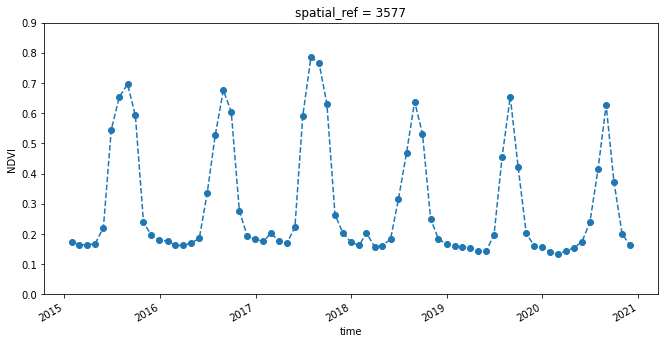

In [7]:
ndvi.plot(figsize=(11,5),linestyle='dashed', marker='o')
plt.ylim(0,0.9);

## Retrieval of surface and root-zone wetness

> `Surface wetness` is measured relative to wettest condition recorded for a location.

> `Rootzone Soil Water Index` is derived from surface relative wetness

In [8]:
# function to load soil moisture data
def load_soil_moisture(lat, lon, time, grid=None, product = 'surface'):
    product_baseurl = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/'
    assert product in ['surface', 'rootzone'], 'product parameter must be surface or root-zone'
    # define a grid that covers the entire area of interest
    lat_range = np.arange(np.max(np.ceil(np.array(lat)*10.+0.5)/10.-0.05),
                          np.min(np.floor(np.array(lat)*10.-0.5)/10.+0.05)-0.05, -0.1)
    lon_range = np.arange(np.min(np.floor(np.array(lon)*10.-0.5)/10.+0.05),
                          np.max(np.ceil(np.array(lon)*10.+0.5)/10.-0.05)+0.05, 0.1)
    # split time window into years
    day_range = np.array(time).astype("M8[D]")
    year_range = np.array(time).astype("M8[Y]")
    if product == 'surface':
        product_name = 'GRAFS_TopSoilRelativeWetness_'
    else: product_name = 'GRAFS_RootzoneSoilWaterIndex_'
    datasets = []
    for year in np.arange(year_range[0], year_range[1]+1, np.timedelta64(1, 'Y')):
        start = np.max([day_range[0], year.astype("M8[D]")])
        end = np.min([day_range[1], (year+1).astype("M8[D]")-1])
        product_url = product_baseurl + product_name +'%s.nc'%str(year)
        print(product_url)
        # data is loaded lazily through OPeNDAP
        ds = xr.open_dataset(product_url)
        # slice before return
        ds = ds.sel(lat=lat_range, lon=lon_range, time=slice(start, end)).compute()
        datasets.append(ds)
    return xr.merge(datasets)

# Retrieve surface soil moisture using query parameters
surface_wetness = load_soil_moisture(lat, lon, time) #grid='nearest'

# retrieve rootzone soil moisture using query parameters
rootzone_wetness = load_soil_moisture(lat, lon, time, product='rootzone') #grid='nearest'

http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2015.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2016.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2017.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2019.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_TopSoilRelativeWetness_2020.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2015.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2016.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2017.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRAFS_RootzoneSoilWaterIndex_2018.nc
http://dapds00.nci.org.au/thredds/dodsC/ub8/global/GRAFS/GRA

## Retrieve precipitation data from ERA5


In [9]:
# # load precipitation data from ERA5
# var_precipitation = 'precipitation_amount_1hour_Accumulation'
# precipitation = load_era5(var_precipitation, lat, lon, time, reduce_func=np.sum, resample='1D')

# # Convert from Meters (m) to Millimeters (mm)
# precipitation[var_precipitation]=precipitation[var_precipitation]*1000

### Convert all datasets to 1D time-series

And resample to common time-step

In [10]:
# precipitation=precipitation[var_precipitation].mean(['lat','lon']).drop('spatial_ref').compute()
surface_wetness=surface_wetness.relative_wetness.mean(['lat','lon'])
rootzone_wetness=rootzone_wetness.soil_water_index.mean(['lat','lon'])

In [11]:
# precipitation=precipitation.resample(time=freq).interpolate("linear")
surface_wetness=surface_wetness.resample(time=freq).interpolate("linear")
rootzone_wetness=rootzone_wetness.resample(time=freq).interpolate("linear")

### Plot all datasets together

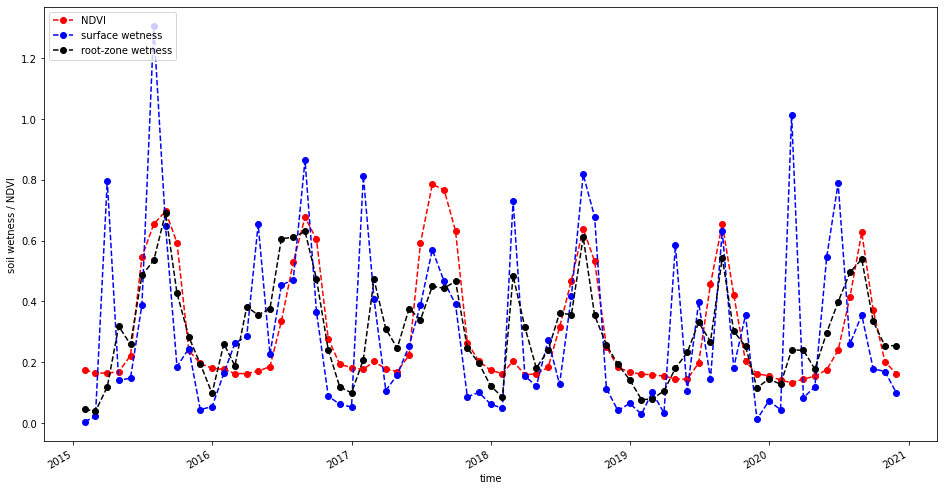

In [12]:
# plot soil moisture with precipitation
fig, ax1 = plt.subplots(figsize=(16,8))
# ax2 = ax1.twinx()
ndvi.plot(ax=ax1,label='NDVI',color='red',linestyle='dashed', marker='o')
surface_wetness.plot(ax = ax1,label='surface wetness',color='blue',linestyle='dashed', marker='o')
rootzone_wetness.plot(ax = ax1,label='root-zone wetness',color='black',linestyle='dashed', marker='o')
# precipitation.plot(ax=ax2,label='precipitation (mm)',color='orange',linestyle='dashed', marker='o')
ax1.set_ylabel('soil wetness / NDVI')
# ax2.set_ylabel('Weekly Accumulated rainfall (mm)')
ax1.legend(loc='upper left')
# ax2.legend(loc='upper right');

## Convert to pandas dataframes

And put into a format that will fit with ml-forecast

In [13]:
#convert to dfs
ndvi=ndvi.drop('spatial_ref').to_dataframe()
surface_wetness=surface_wetness.to_dataframe()
rootzone_wetness=rootzone_wetness.to_dataframe()
# precipitation=precipitation.to_dataframe()

#add other variables to ndvi
ndvi['surface_wetness']=surface_wetness['relative_wetness']
ndvi['rootzone_wetness']=rootzone_wetness['soil_water_index']
# ndvi['rainfall']=precipitation['precipitation_amount_1hour_Accumulation']

#drop an rows with nans
ndvi = ndvi.dropna()
ndvi.head()

,NDVI,surface_wetness,rootzone_wetness
time,,,
2015-01-31,0.174863,0.004288,0.045162
2015-02-28,0.164514,0.021699,0.038326
2015-03-31,0.163742,0.796978,0.118628
2015-04-30,0.168693,0.140458,0.318247
2015-05-31,0.221592,0.147268,0.258207


## Use VAR to make forecast

## Back test

In [14]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

In [15]:
#creating the train and validation set
train = ndvi.head(int(len(ndvi)*0.8))
valid = ndvi.tail(int(len(ndvi)*0.2))

model = VAR(endog=train, freq=freq)
model_fit = model.fit(ic='aic')
# lag_order = model_fit.k_ar
# print(lag_order)

# make prediction on validation
pred = model_fit.forecast(model.y, steps=len(valid))  #valid.values[-lag_order:]

/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  # This is added back by InteractiveShellApp.init_path()


In [16]:
#converting predictions to dataframe
cols = ndvi.columns
predictions = pd.DataFrame(index=range(0,len(pred)), columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(pred)):
        predictions.iloc[i][j] = pred[i][j]
        
predictions.index = pd.date_range(freq=freq, start=train.index[-1], periods=len(predictions)+1)[1:]
predictions.head()

,NDVI,surface_wetness,rootzone_wetness
2019-09-30,0.728927,0.481558,0.402004
2019-10-31,0.632423,0.258264,0.42747
2019-11-30,0.50019,-0.0029995,0.109491
2019-12-31,0.326045,0.0432771,0.0835885
2020-01-31,0.162166,0.131955,0.0200064


In [17]:
#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', round(math.sqrt(mean_squared_error(predictions[[i]], valid[[i]])),2))

rmse value for NDVI is :  0.29
rmse value for surface_wetness is :  0.34
rmse value for rootzone_wetness is :  0.16


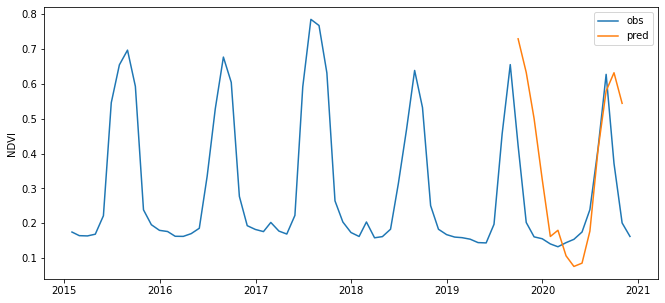

In [18]:
plt.figure(figsize=(11,5))
plt.plot(ndvi.index, ndvi['NDVI'], label='obs')
plt.plot(predictions.index, predictions[['NDVI']], label='pred')
plt.ylabel('NDVI')
plt.legend();

### Forecast

In [19]:
#make final predictions
model = VAR(endog=ndvi,freq=freq)
model_fit = model.fit(ic='aic')
# lag_order = model_fit.k_ar
# print(lag_order)

In [20]:
# make prediction on validation
pred = model_fit.forecast(model.y, steps=12)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  


In [21]:
#converting predictions to dataframe
cols = ndvi.columns
predictions = pd.DataFrame(index=range(0,len(pred)), columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(pred)):
        predictions.iloc[i][j] = pred[i][j]

predictions.index = pd.date_range(freq=freq, start=ndvi.index[-1], periods=len(predictions)+1)[1:]
predictions.head()

,NDVI,surface_wetness,rootzone_wetness
2020-12-31,0.165264,-0.0103995,0.0435122
2021-01-31,0.189409,0.413275,0.21122
2021-02-28,0.0896255,0.58382,0.311045
2021-03-31,0.111598,0.523738,0.358786
2021-04-30,0.138552,0.187196,0.269225


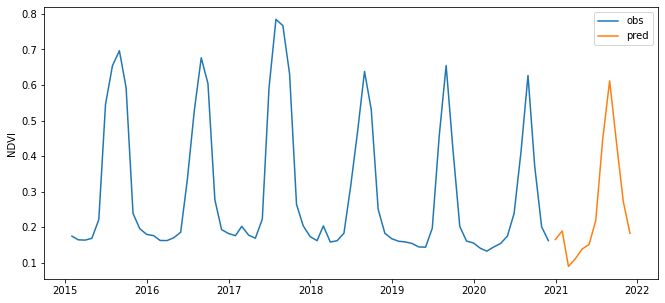

In [22]:
plt.figure(figsize=(11,5))
plt.plot(ndvi.index, ndvi['NDVI'], label='obs')
plt.plot(predictions.index, predictions[['NDVI']], label='pred')
plt.ylabel('NDVI')
plt.legend();